In [1]:
!pip install zarr ome-zarr

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=620c40fa7eb77c6e04ebbe635bbf7be4c2da36004861d831a8fa16e3aa4abae1
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
  Attempting uninstall: dask
    Found existing installation: dask 2024.9.1
    Uninstalling dask-2024.9.1:
      Successfully uninstalled dask-2024.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

# CZII - CryoET Object Detection using U-Net

### To implement object detection using U-Net, which is a popular architecture for image segmentation tasks, we can use it to segment objects from your tomogram slices. U-Net is particularly effective for pixel-level classification, making it ideal for segmenting structures in CZII - CryoET  images. Use the trained model to predict object regions on new tomogram slices.

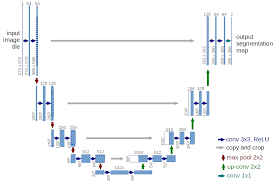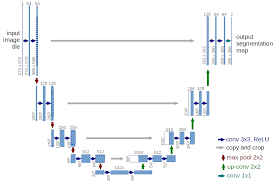

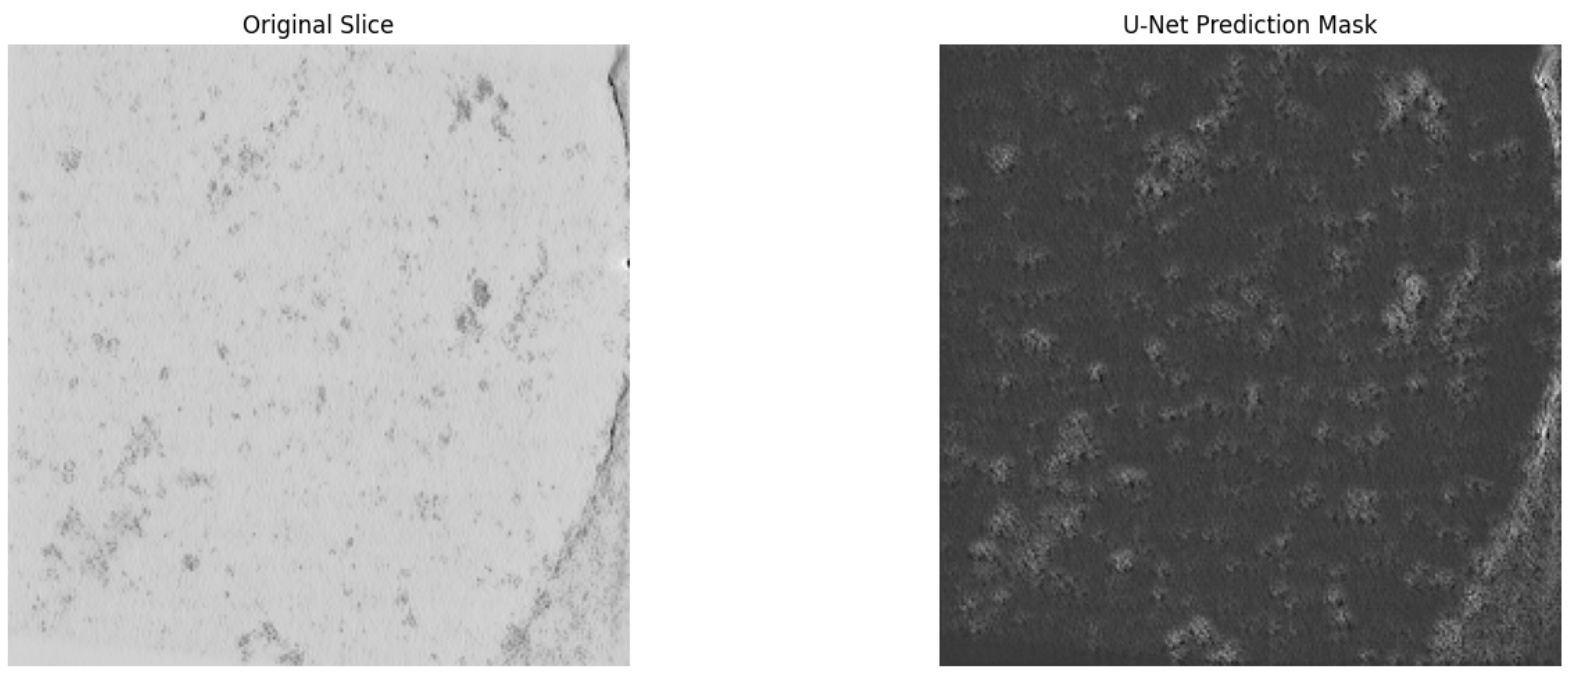

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import zarr
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# Load the denoised file from the given path
zarr_file_path = '/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns/TS_5_4/VoxelSpacing10.000/isonetcorrected.zarr'
TS_5_4_isonetcorrected = zarr.open(zarr_file_path, mode='r')
TS_5_4_isonetcorrected

<zarr.hierarchy.Group '/' read-only>

In [4]:
# Access the different resolution data
tomogram_data_0 = TS_5_4_isonetcorrected[0]  # scale 0 (highest resolution)
tomogram_data_1 = TS_5_4_isonetcorrected[1]  # scale 1
tomogram_data_2 = TS_5_4_isonetcorrected[2]  # scale 2

In [5]:
# Select a slice for testing
slice_idx_0 = 50  # Choose a slice index for the highest resolution
slice_data_0 = tomogram_data_0[slice_idx_0, :, :]

In [6]:
# Preprocess image (normalize to [0, 1])
slice_data_0 = slice_data_0.astype(np.float32) / np.max(slice_data_0)

In [7]:
# U-Net Architecture
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)
    
    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Expanding Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build the model
model = unet_model()

# summary the model 
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  4,719,104 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 34,512,193 (131.65 MB)

 Trainable params: 34,512,193 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

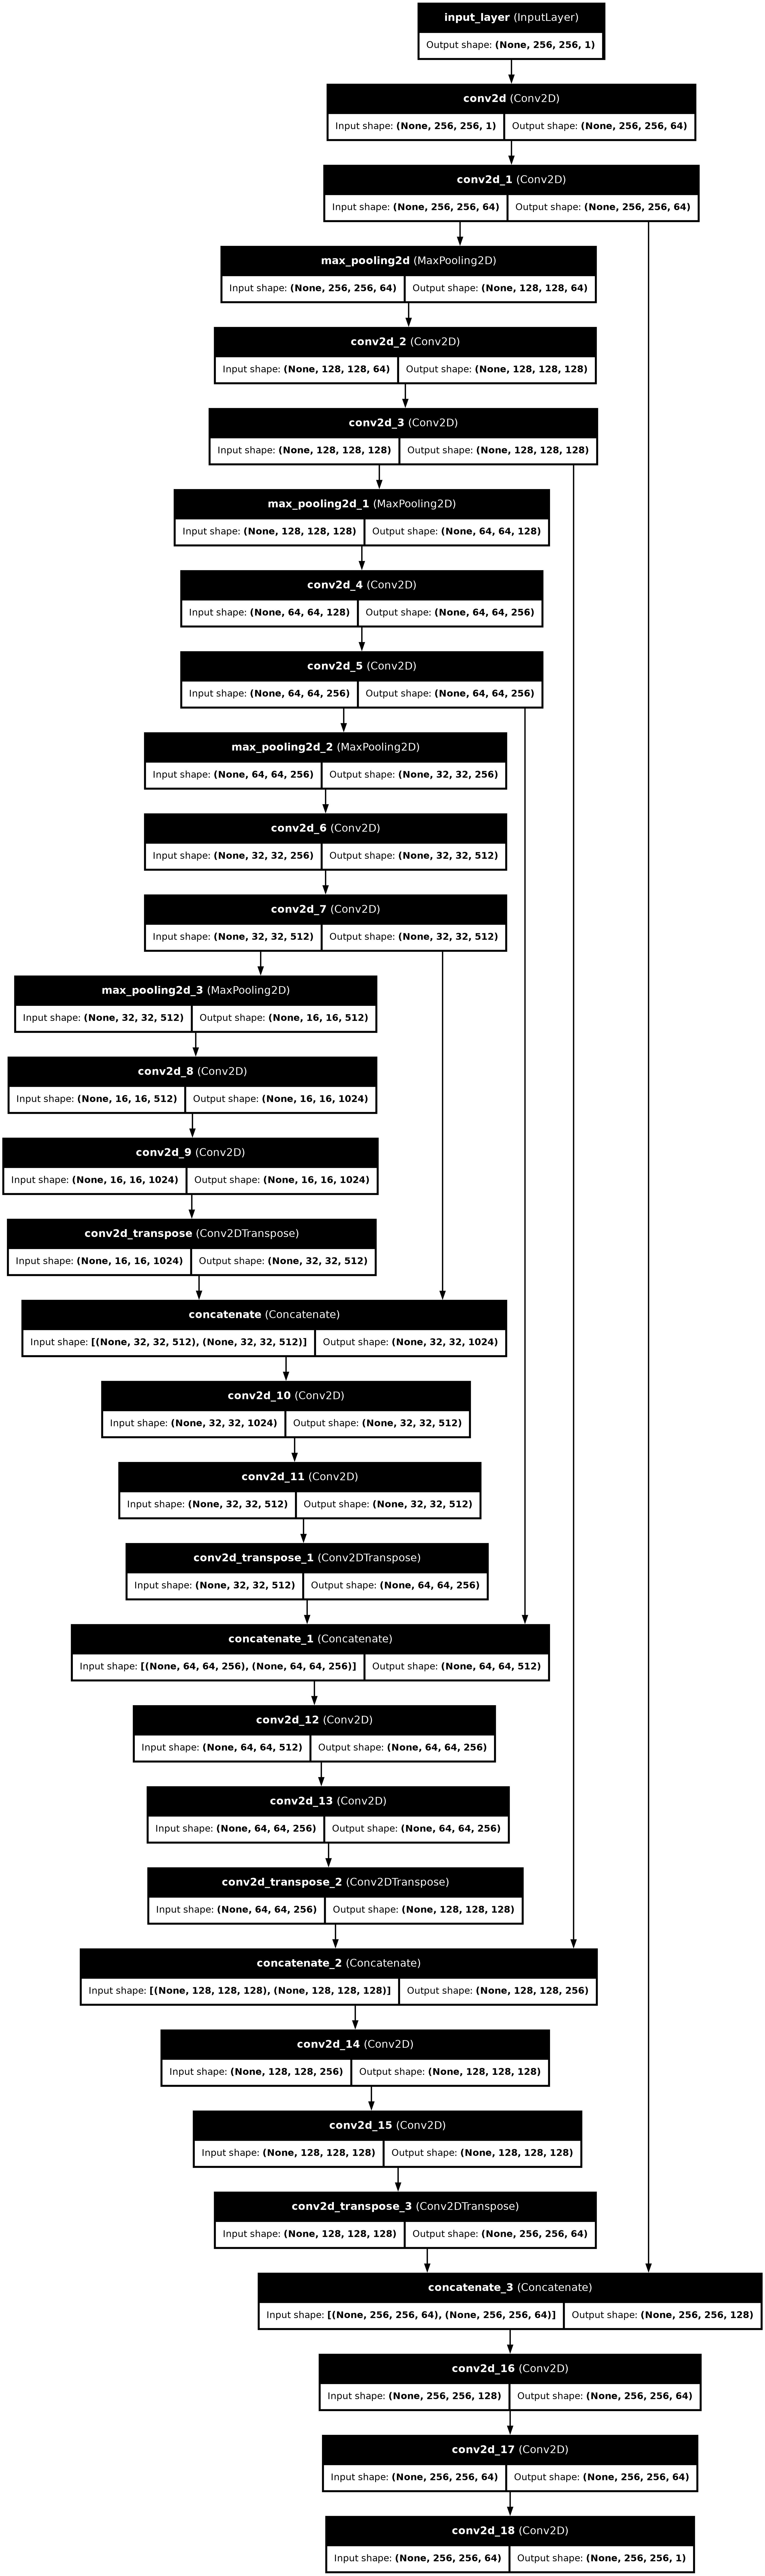

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [9]:
#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Prepare input for prediction (reshape to (256, 256, 1) and expand dimensions for batch)
slice_data_0_resized = cv2.resize(slice_data_0, (256, 256))
slice_data_0_resized = slice_data_0_resized[..., np.newaxis]

In [11]:
# Prediction using U-Net (fake prediction for this demo)
prediction = model.predict(np.expand_dims(slice_data_0_resized, axis=0))
prediction [:1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[[0.50011057],
         [0.4997312 ],
         [0.49991733],
         ...,
         [0.5001101 ],
         [0.4996921 ],
         [0.50342554]],

        [[0.50012016],
         [0.5001966 ],
         [0.5000538 ],
         ...,
         [0.5028462 ],
         [0.4996482 ],
         [0.50834525]],

        [[0.5000402 ],
         [0.50034094],
         [0.5004309 ],
         ...,
         [0.50702405],
         [0.50508523],
         [0.51254743]],

        ...,

        [[0.50033766],
         [0.5003354 ],
         [0.500555  ],
         ...,
         [0.5025768 ],
         [0.5017162 ],
         [0.50175697]],

        [[0.5001968 ],
         [0.5001688 ],
         [0.500657  ],
         ...,
         [0.502489  ],
         [0.5015398 ],
         [0.5008401 ]],

        [[0.5001581 ],
         [0.50032514],
         [0.50060177],
         ...,
         [0.50265783],
         [0.5028751 ],
         [0.50184005]]]], dtype=float32)

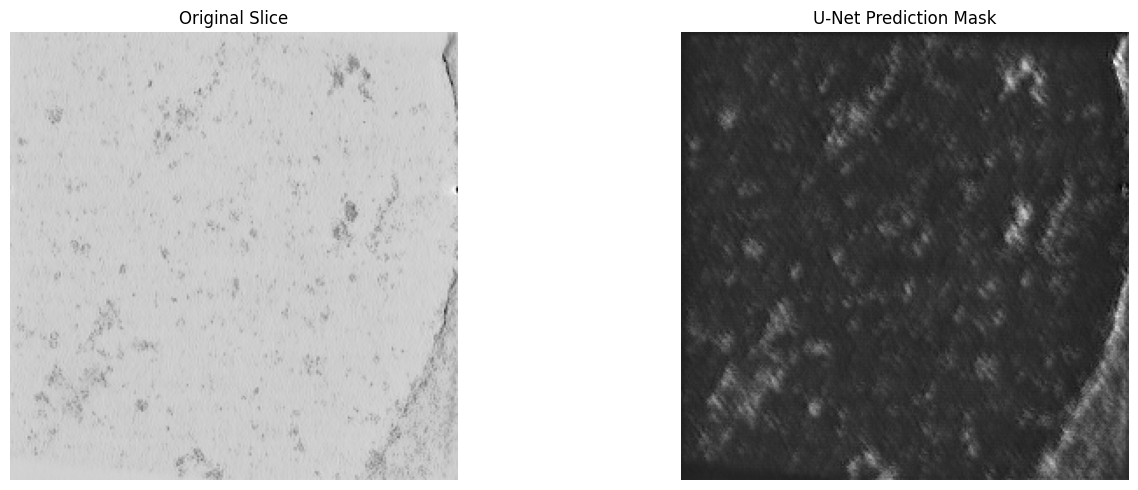

In [12]:
# Visualize the original slice and the prediction mask
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(slice_data_0_resized.squeeze(), cmap='gray')
axes[0].set_title("Original Slice")
axes[0].axis('off')

axes[1].imshow(prediction.squeeze(), cmap='gray')
axes[1].set_title("U-Net Prediction Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()